# Klasyfikacja spiral — Keras i PyTorch (ten sam problem, ta sama architektura)

Cel: prosto i zwięźle pokazać, jak rozwiązać ten sam problem klasyfikacji danych spiralnych w Keras i w PyTorch.

Plan (powtarzamy 1–6 dla obu frameworków):
1. Generacja danych (2 klasy, rozłączne spirale)
2. Wykres punktowy (scatter)
3. Model MLP: wejście 2 → 8 → 8 → wyjście (1)
4. Trening
5. Predykcja na zbiorze testowym (accuracy)
6. Wizualizacja granicy decyzyjnej (decision boundary)



## Generacja danych

Ten fragment kodu generuje **syntetyczny zbiór danych spiralnych 2D** – dwie klasy punktów ułożonych w kształt zakręconych spiral, które owijają się wokół wspólnego środka.
To popularny przykład w uczeniu maszynowym, ponieważ granica decyzyjna nie jest liniowa, więc wymaga bardziej złożonych modeli (np. sieci neuronowych).

* Każda klasa odpowiada jednej spirali.
* Parametry `twist`, `offset` i `noise` kontrolują: jak mocno spirala się owija, jak bardzo są od siebie przesunięte oraz jak rozproszone są punkty.
* Dane są zwracane jako macierz cech `X` (punkty 2D) i wektor etykiet `y` (0 lub 1).
* Na końcu dane dzielone są na zbiory treningowy i testowy.

---

### Kod z komentarzami inline

```python

```

---

👉 Chcesz, żebym od razu dodał też **wizualizację spirali** (scatter plot klas 0 i 1), żeby było jasne, jak wyglądają wygenerowane dane?


In [5]:
# 1) Generacja danych spiralnych (2D, 2 klasy)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)  # dla powtarzalności wyników

def make_spiral(n_per_class=500, noise=0.05, twist=4*np.pi, offset=np.pi+0.3):
    # Kąt rosnący od 0 do 'twist' (np. 4π → 2 pełne obroty spirali)
    theta = np.linspace(0, twist, n_per_class)
    # Promień rosnący od środka (spirala rozwija się na zewnątrz)
    r = np.linspace(0.0, 1.5, n_per_class)

    # --- Spirala klasy 0 ---
    x0 = r * np.cos(theta) + noise * np.random.randn(n_per_class)  # współrzędna X + szum
    y0 = r * np.sin(theta) + noise * np.random.randn(n_per_class)  # współrzędna Y + szum
    c0 = np.zeros(n_per_class, dtype=np.int64)  # etykiety = 0

    # --- Spirala klasy 1 (przesunięta o 'offset') ---
    x1 = r * np.cos(theta + offset) + noise * np.random.randn(n_per_class)
    y1 = r * np.sin(theta + offset) + noise * np.random.randn(n_per_class)
    c1 = np.ones(n_per_class, dtype=np.int64)   # etykiety = 1

    # Łączenie danych w jedną macierz cech X i wektor etykiet y
    X = np.vstack([np.c_[x0, y0], np.c_[x1, y1]]).astype(np.float32)  # shape: (2*n_per_class, 2)
    y = np.concatenate([c0, c1])  # shape: (2*n_per_class,)
    return X, y

# Test: wygeneruj 2 spirale po 400 punktów
X, y = make_spiral(n_per_class=400, noise=0.05)

# Podział na zbiór treningowy i testowy (z zachowaniem proporcji klas)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

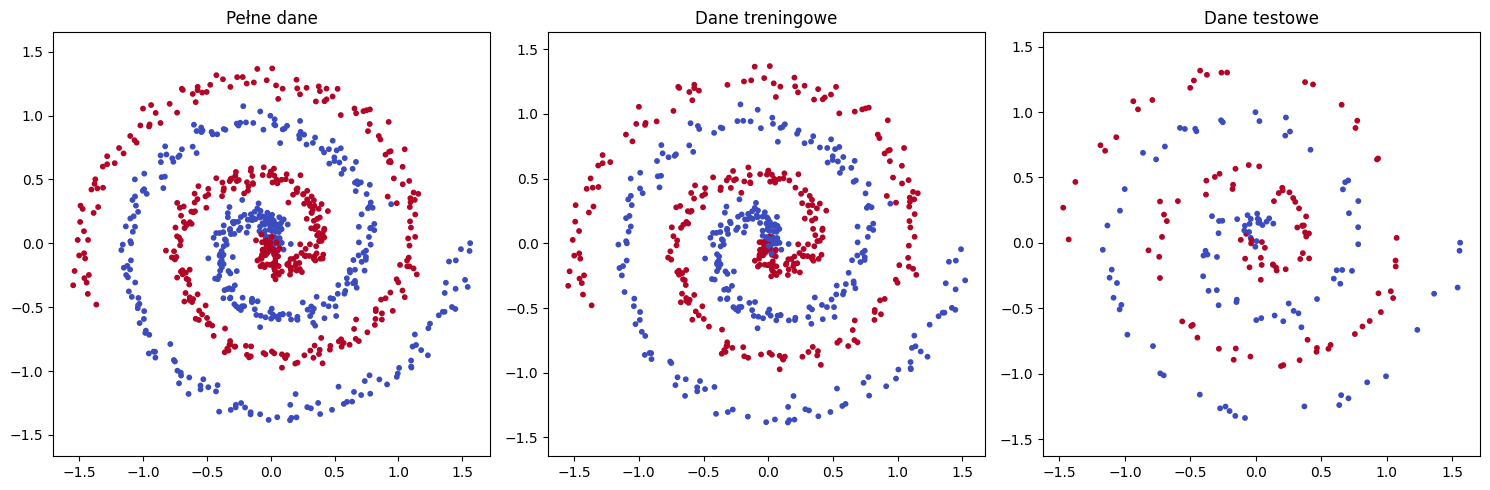

In [6]:
# 2) Wykres punktowy (scatter) danych uczących

# Rysowanie obok siebie
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Wszystkie dane
axes[0].scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10)
axes[0].set_title("Pełne dane")
axes[0].axis("equal")

# Dane treningowe
axes[1].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm", s=10)
axes[1].set_title("Dane treningowe")
axes[1].axis("equal")

# Dane testowe
axes[2].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="coolwarm", s=10)
axes[2].set_title("Dane testowe")
axes[2].axis("equal")

plt.tight_layout()
plt.show()


In [7]:
# Helper: 6) rysowanie granicy decyzyjnej dla funkcji predykcyjnej
from typing import Callable

def plot_decision_boundary(predict_fn: Callable[[np.ndarray], np.ndarray], X, y, title="Boundary"):
    # Siatka punktów na obszarze danych
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

    # Predykcja klas na siatce
    zz = predict_fn(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, zz, levels=1, alpha=0.25, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, edgecolor="k", linewidth=0.1)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


## KERAS: architektura (2→8→8→1)

- Architektura: Dense(8, relu) → Dense(8, relu) → Dense(1, sigmoid)
- Loss: binary crossentropy, optymalizator Adam
- Trening kilku setek epok, mała sieć (kod krótki i zwięzły)


Intuicja podpowiada: *„mam 2 klasy → powinienem mieć 2 neurony na wyjściu”*.
Ale w przypadku **klasyfikacji binarnej** nie trzeba – jeden neuron w zupełności wystarczy.

---

### 🔎 Dlaczego wystarcza **1 neuron**?

* Model zwraca **jeden logit** (z).
* Po przejściu przez **sigmoid** mamy wartość $p = \sigma(z) \in (0,1)$.
* Interpretujemy to jako:

  * $p$ = prawdopodobieństwo, że przykład należy do **klasy 1**
  * $1-p$ = prawdopodobieństwo, że należy do **klasy 0**

Czyli cała informacja o 2 klasach jest zakodowana w jednym wymiarze – bo suma prawdopodobieństw i tak musi być równa 1.

---

### 🔎 A kiedy **2 neurony na wyjściu**?

* Jeśli używasz **softmax** – wtedy masz wektor ([p_0, p_1]), który jawnie reprezentuje rozkład na klasy.
* To bardziej naturalne przy **wieloklasowej klasyfikacji** (3+ klas), bo wtedy musisz mieć jeden neuron na każdą klasę.

---

### 🔑 Podsumowanie

* **Binarna klasyfikacja** → najczęściej **1 neuron + sigmoid** + `binary_crossentropy` (Keras) albo `BCEWithLogitsLoss` (PyTorch).
* **Wieloklasowa klasyfikacja** → **k neuronów + softmax** + `categorical_crossentropy` (Keras) albo `CrossEntropyLoss` (PyTorch).


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2025-11-23 12:43:08.891869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras — accuracy (test): 0.965


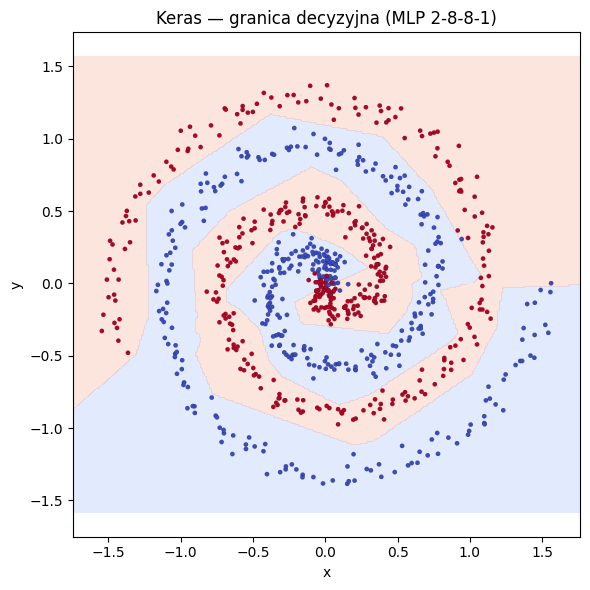

In [10]:

# 3) Model Keras (MLP 2-8-8-1)
model_keras = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid"),  # wyjście 1D dla klasy 1
])

model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

# 4) Trening (kilkaset epok wystarcza dla 8-8)
hist = model_keras.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500, batch_size=64, verbose=0
)

# 5) Predykcja i accuracy na teście
keras_test_probs = model_keras.predict(X_test, verbose=0).ravel()
keras_test_pred = (keras_test_probs >= 0.5).astype(np.int64)
keras_acc = (keras_test_pred == y_test).mean()
print(f"Keras — accuracy (test): {keras_acc:.3f}")

# 6) Granica decyzyjna (Keras)
plot_decision_boundary(
    predict_fn=lambda pts: (model_keras.predict(pts, verbose=0).ravel() >= 0.5).astype(np.int64),
    X=X, y=y, title="Keras — granica decyzyjna (MLP 2-8-8-1)"
)


## PYTORCH: ta sama architektura (2→8→8→1) i ten sam zbiór danych

- Używamy BCEWithLogitsLoss (dlatego model zwraca logit; sigmoid tylko do predykcji)
- Optymalizator Adam, lr=1e-2; parę set epok


PyTorch — accuracy (test): 0.865


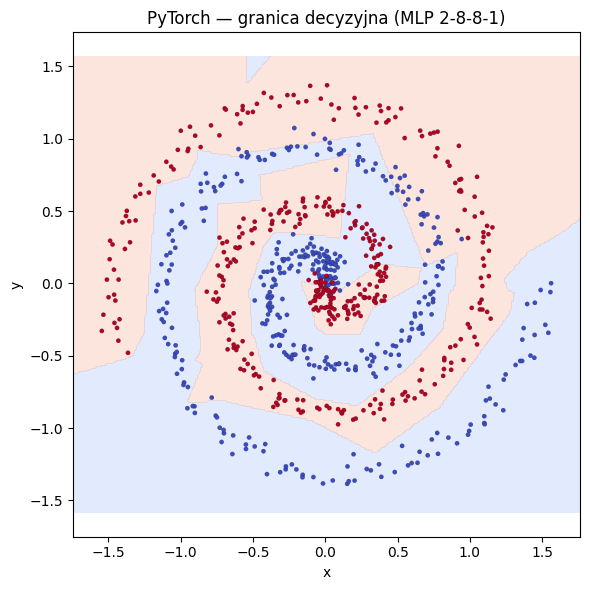

In [14]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)

# 3) Model PyTorch (logity, bez sigmoid w forward)
class SpiralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),  # 1 logit
        )
    def forward(self, x):
        return self.layers(x)

model_torch = SpiralNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=1e-2)

# Dane do tensora/dataloaderów
Xtr_t = torch.from_numpy(X_train)
ytr_t = torch.from_numpy(y_train.astype(np.float32)).view(-1, 1)  # kształt (N,1)
Xte_t = torch.from_numpy(X_test)
yte_t = torch.from_numpy(y_test.astype(np.float32)).view(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)

# 4) Trening pętla
model_torch.train()
for epoch in range(1000):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model_torch(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

# 5) Predykcja i accuracy na teście
model_torch.eval()
with torch.no_grad():
    logits = model_torch(Xte_t).squeeze(1)
    probs = torch.sigmoid(logits)
    pred = (probs >= 0.5).long().numpy()
acc_torch = (pred == y_test).mean()
print(f"PyTorch — accuracy (test): {acc_torch:.3f}")


def predict_fn(pts):
    with torch.no_grad():
        logits = model_torch(torch.from_numpy(pts))
        probs = torch.sigmoid(logits).squeeze(1).numpy()
    return (probs >= 0.5).astype(np.int64)

plot_decision_boundary(
    predict_fn=predict_fn,
    X=X, y=y, title="PyTorch — granica decyzyjna (MLP 2-8-8-1)"
)




### 🔑 Główne powody różnic

1. **Inicjalizacja wag**

   * Keras domyślnie używa **Glorot/Xavier uniform** w `Dense` + odpowiednią inicjalizację biasów (zerowe).
   * PyTorch `nn.Linear` używa **Uniform(-1/√in, 1/√in)**, co daje trochę inne rozrzuty wag.
     📌 To ma duże znaczenie przy spiralach, bo problem jest trudny i wymaga „dobrego startu”.

2. **Optymalizator Adam**

   * W Keras: `Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-7)`
   * W PyTorch: `Adam(lr=1e-2, betas=(0.9, 0.999), eps=1e-8)`
     → to subtelna różnica (`epsilon` o rząd wielkości mniejszy), ale czasem mocno wpływa na stabilność przy dużym LR.

3. **Batch handling**

   * Keras automatycznie robi shuffle w `fit()`.
   * Ty też masz `shuffle=True` w `DataLoader`, więc tutaj jest podobnie, ale np. różna kolejność batchy przy `random_state` = 42 może sprawić, że uczenie idzie inaczej.

4. **Loss i numeryka**

   * Keras w `binary_crossentropy` z aktywacją sigmoid **robi clipping** predykcji (np. [1e-7, 1-1e-7]), żeby uniknąć log(0).
   * PyTorch `BCEWithLogitsLoss` jest stabilna numerycznie (łączy sigmoid+log w jednym), ale jednak algorytmicznie nie jest 1:1 identyczny z implementacją TF/Keras.

5. **Reguły treningowe**

   * Keras automatycznie przełącza model w `train()` i `eval()`, dba o dropout/batchnorm.
   * W PyTorch Ty musisz to pilnować ręcznie (`model.train()`, `model.eval()` – i zrobiłeś to dobrze 👍).
   * Ale w PyTorch `DataLoader` może powodować subtelnie inne rozkłady danych niż w Keras.

---

### 🔧 Co możesz zrobić, żeby wyrównać szanse PyTorch:

1. **Ustawić tę samą inicjalizację wag**:

   ```python
   def init_weights(m):
       if isinstance(m, nn.Linear):
           nn.init.xavier_uniform_(m.weight)   # tak jak w Keras Dense
           nn.init.zeros_(m.bias)
   model_torch.apply(init_weights)
   ```
2. **Zmienić epsilon w Adamie**:

   ```python
   optimizer = torch.optim.Adam(model_torch.parameters(), lr=1e-2, eps=1e-7)
   ```
3. **Pobawić się lr** – w spiralach czasem 5e-3 jest lepsze niż 1e-2.

---

📊 W praktyce:

* Jeśli ustawisz Xavier init + eps=1e-7 w PyTorch, wyniki powinny być **bardzo zbliżone do Keras**.
* To nie framework decyduje, tylko **drobne szczegóły implementacyjne i numeryczne**.



PyTorch — accuracy (test): 0.945


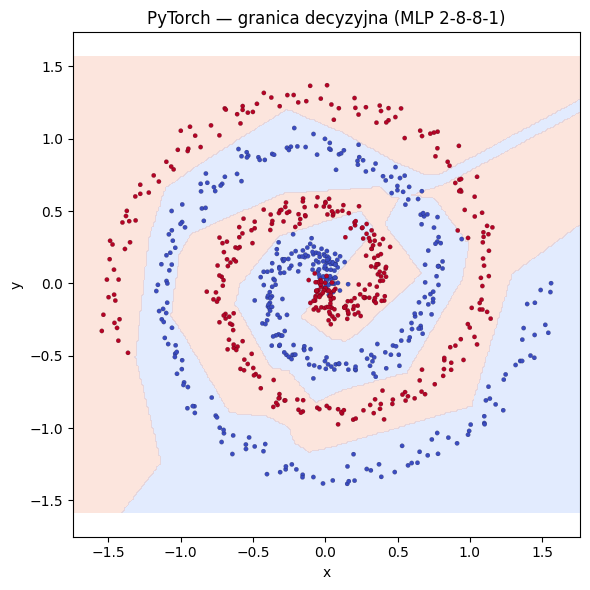

In [15]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)

# 3) Model PyTorch (logity, bez sigmoid w forward)
class SpiralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),  # 1 logit
        )
    def forward(self, x):        
        return self.layers(x)

model_torch = SpiralNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=1e-2,  eps=1e-7)  # poprawa eps

# Dane do tensora/dataloaderów
Xtr_t = torch.from_numpy(X_train)
ytr_t = torch.from_numpy(y_train.astype(np.float32)).view(-1, 1)  # kształt (N,1)
Xte_t = torch.from_numpy(X_test)
yte_t = torch.from_numpy(y_test.astype(np.float32)).view(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)

# poprawa wag
def init_weights(m):
   if isinstance(m, nn.Linear):
       nn.init.xavier_uniform_(m.weight)   # tak jak w Keras Dense
       nn.init.zeros_(m.bias)
model_torch.apply(init_weights)

def train(model, optimizer, criterion):
    # 4) Trening pętla
    model_torch.train()
    for epoch in range(1000):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model_torch(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

train(model_torch, optimizer, criterion)

# 5) Predykcja i accuracy na teście
model_torch.eval()
with torch.no_grad():
    logits = model_torch(Xte_t).squeeze(1)
    probs = torch.sigmoid(logits)
    pred = (probs >= 0.5).long().numpy()
acc_torch = (pred == y_test).mean()
print(f"PyTorch — accuracy (test): {acc_torch:.3f}")


def predict_fn(pts):
    with torch.no_grad():
        logits = model_torch(torch.from_numpy(pts))
        probs = torch.sigmoid(logits).squeeze(1).numpy()
    return (probs >= 0.5).astype(np.int64)

plot_decision_boundary(
    predict_fn=predict_fn,
    X=X, y=y, title="PyTorch — granica decyzyjna (MLP 2-8-8-1)"
)


## Architektura 2 - 8 - 8 - 2


### 🔄 Zmiany w architekturze i pipeline

1. **Warstwa wyjściowa**

   * **Stara wersja:**
     `nn.Linear(8, 1)` → jeden logit → potem sigmoid dawał prawdopodobieństwo klasy „1”.
   * **Nowa wersja:**
     `nn.Linear(8, 2)` → dwa logity (dla klasy 0 i 1) → softmax jest wewnętrznie wbudowany w `CrossEntropyLoss`.

2. **Funkcja straty**

   * **Stara:** `nn.BCEWithLogitsLoss()` – binarna entropia krzyżowa, działa na jednym logitcie i targetach float `(N,1)` (0.0/1.0).
   * **Nowa:** `nn.CrossEntropyLoss()` – wieloklasowa entropia krzyżowa, działa na logitach `(N, 2)` i targetach `LongTensor (N,)` (etykiety 0 lub 1).

3. **Format etykiet**

   * **Stara:** `ytr_t = ...astype(np.float32)).view(-1,1)` → `(N,1)` float.
   * **Nowa:** `ytr_t = ...astype(np.int64)` → `(N,)` long.

4. **Predykcja**

   * **Stara:** używałeś `sigmoid` + progowania `>=0.5`.
   * **Nowa:** używasz `argmax(dim=1)`, czyli wybierasz logit o większej wartości.

5. **Interpretacja**

   * **Stara:** model przewidywał tylko *prawdopodobieństwo klasy pozytywnej*.
   * **Nowa:** model przewiduje pełny *rozkład prawdopodobieństwa* na dwie klasy (choć w praktyce binarnej to tylko `p` i `1-p`).

6. **Dodatki**

   * W starej wersji dodałeś własną inicjalizację wag (`xavier_uniform_`), w nowej – zostawiłeś domyślną inicjalizację PyTorch.

---

### ✨ Podsumowanie

* **MLP 2-8-8-1 (sigmoid)** → klasyfikacja binarna „na skróty”: 1 wyjście, sigmoid, BCE, targety `(N,1)` float.
* **MLP 2-8-8-2 (softmax)** → klasyfikacja binarna w trybie wieloklasowym: 2 wyjścia, softmax (implicit), CrossEntropy, targety `(N,)` long, predykcja przez `argmax`.

Obie wersje rozwiązują **ten sam problem binarnej klasyfikacji**, ale nowa architektura jest bardziej ogólna i „wzorcowa” – dokładnie tak samo działałaby dla 3, 4, czy 10 klas.



PyTorch — accuracy (test): 0.925


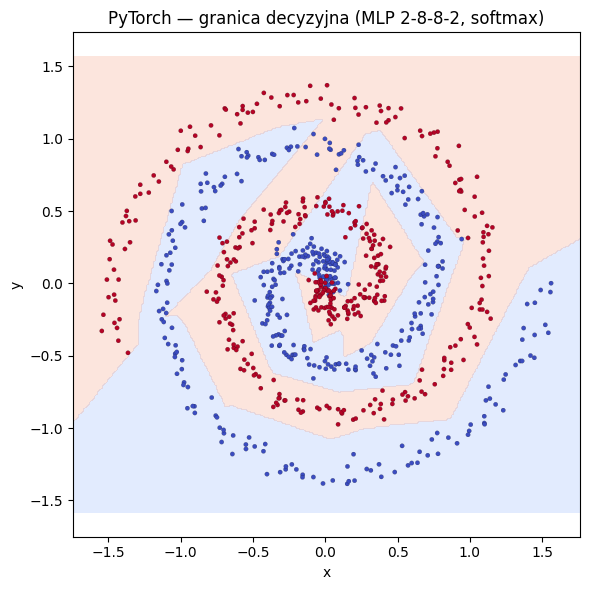

In [12]:

ytr_t = torch.from_numpy(y_train.astype(np.int64))  # shape (N,)
yte_t = torch.from_numpy(y_test.astype(np.int64))   # shape (N,)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)


# ---------------------------------------------------
# Model PyTorch z softmaxem (2 wyjścia)
class SpiralNetSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # 2 logity (dla klas 0 i 1)
        )
    def forward(self, x):
        return self.layers(x)  # UWAGA: bez softmaxa! (CrossEntropyLoss zrobi go sama)

# ---------------------------------------------------
# Inicjalizacja
torch.manual_seed(42)
model_torch = SpiralNetSoftmax()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=1e-2, eps=1e-7)

# ---------------------------------------------------
# Trening


train(model_torch, optimizer, criterion)

# ---------------------------------------------------
# Ewaluacja (test accuracy)
model_torch.eval()
with torch.no_grad():
    logits = model_torch(Xte_t)           # (N, 2)
    pred = logits.argmax(dim=1)           # klasa = argmax po logitach
acc_torch = (pred.numpy() == y_test).mean()
print(f"PyTorch — accuracy (test): {acc_torch:.3f}")

# ---------------------------------------------------
# Predykcja do granicy decyzyjnej
def predict_fn(pts):
    with torch.no_grad():
        logits = model_torch(torch.from_numpy(pts))
        return logits.argmax(dim=1).numpy()

plot_decision_boundary(
    predict_fn=predict_fn,
    X=X, y=y, title="PyTorch — granica decyzyjna (MLP 2-8-8-2, softmax)"
)


## 2-8-8-2 w Keras

Keras — accuracy (test): 0.865


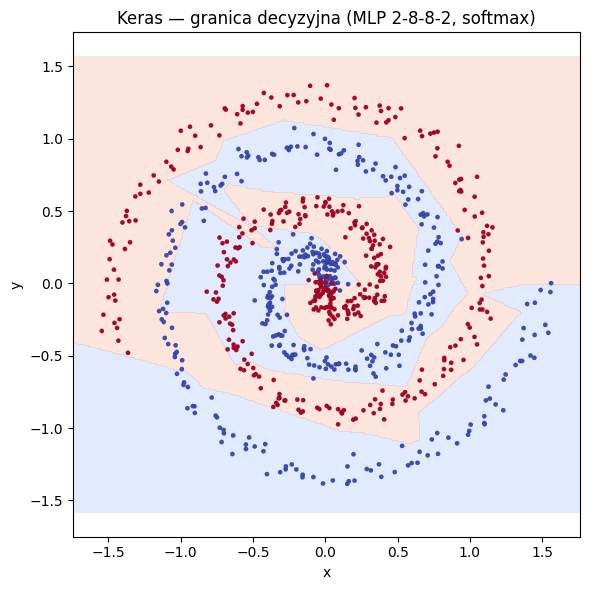

In [13]:

# 3) Model Keras (MLP 2-8-8-1 → zmieniamy na 2-8-8-2)
model_keras = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(8, activation="relu"),
    # zamiast 1 neuronu z sigmoid:
    # layers.Dense(1, activation="sigmoid")
    # → dajemy 2 neurony z softmax
    layers.Dense(2, activation="softmax"),   # wyjście 2D dla klas [0, 1]
])

# kompilacja:
# zamiast binary_crossentropy (bo było 1 wyjście i sigmoid),
# trzeba użyć sparse_categorical_crossentropy (bo mamy 2 wyjścia i etykiety 0/1 jako int)
model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

# 4) Trening (tu zostaje tak samo – dane i parametry się nie zmieniają)
hist = model_keras.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500, batch_size=64, verbose=0
)

# 5) Predykcja i accuracy na teście
# zamiast .ravel() i progowania >=0.5 (dla sigmoid),
# używamy argmax po osi klas (dla softmax)
keras_test_probs = model_keras.predict(X_test, verbose=0)   # shape (N,2)
keras_test_pred = keras_test_probs.argmax(axis=1)           # wybór klasy
keras_acc = (keras_test_pred == y_test).mean()
print(f"Keras — accuracy (test): {keras_acc:.3f}")

# 6) Granica decyzyjna (Keras)
# zamiast porównania >=0.5, używamy argmax
plot_decision_boundary(
    predict_fn=lambda pts: model_keras.predict(pts, verbose=0).argmax(axis=1),
    X=X, y=y, title="Keras — granica decyzyjna (MLP 2-8-8-2, softmax)"
)
